Dataset from Kaggle: https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists?select=aug_test.csv

## Data Import and EDA

In [1]:
import warnings

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, GridSearchCV
from category_encoders import LeaveOneOutEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

# p much in practice:
# *if you want to use GradientBoostingClassifier
#     * use XGBClassifier instead
# *if you want to use GradientBoostingRegressor
#     * use XGBRegressor instead
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# https://gist.github.com/AdamSpannbauer/c99c366b0c7d5b6c4920a46c32d738e5

def print_vif(x):
    """Utility for checking multicollinearity assumption

    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

Kaggle provided the train and test data but the test data doesn't have our target variable so for the purpose of this project, we'll only look at the train data. 

In [3]:
df=pd.read_csv("aug_train.csv")
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


We want to try to categorize whether an employee is looking fo a job change or not, which is measures by the 'target' variable. 


In [4]:
df.shape

(19158, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [6]:
df.isna().mean()

enrollee_id               0.000000
city                      0.000000
city_development_index    0.000000
gender                    0.235306
relevent_experience       0.000000
enrolled_university       0.020148
education_level           0.024011
major_discipline          0.146832
experience                0.003393
company_size              0.309949
company_type              0.320493
last_new_job              0.022080
training_hours            0.000000
target                    0.000000
dtype: float64

So it looks like we have a decent amount of nulls.
Let's see what happens if we drop them all

In [7]:
df_nona=df.dropna()

In [8]:
df_nona.shape

(8955, 14)

We lose a good amount of our data. We have enough to work with but let's try to save as much as possible. 

In [9]:
df=df.drop(columns=['gender', 'enrollee_id'], errors='ignore')

In [10]:
df.dropna().shape

(11179, 12)

Looks like by dropping gender we save a couple thousand rows and all the other rows seem like they could be important for 

<AxesSubplot:xlabel='education_level', ylabel='count'>

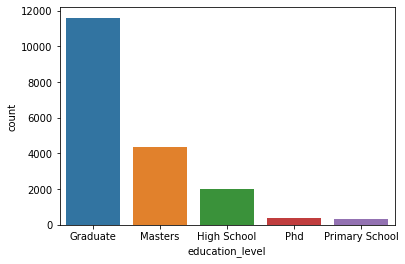

In [11]:
sns.countplot(x='education_level', data=df)

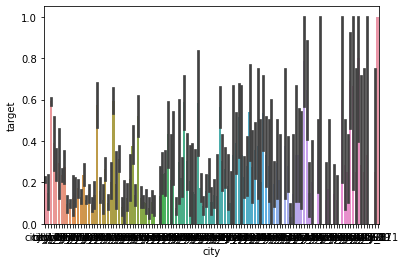

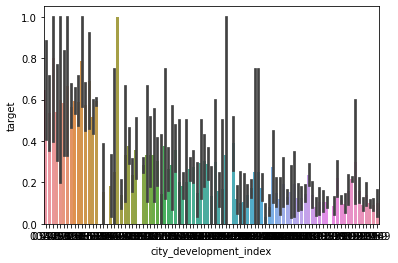

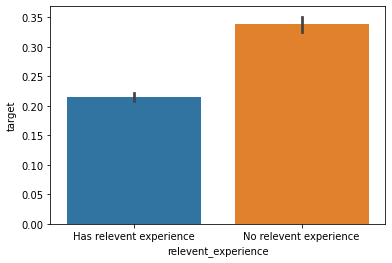

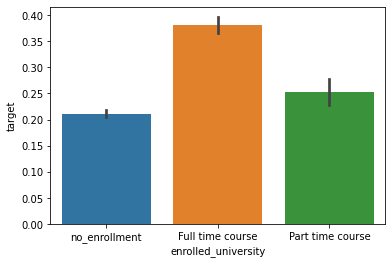

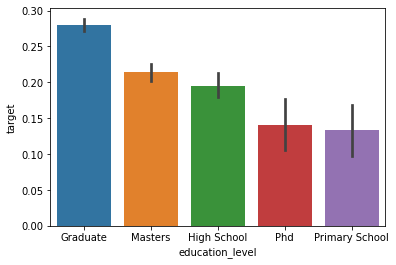

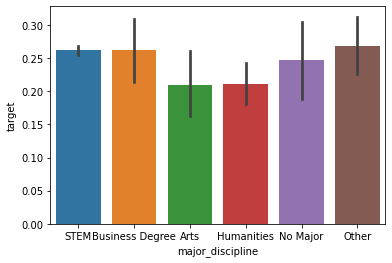

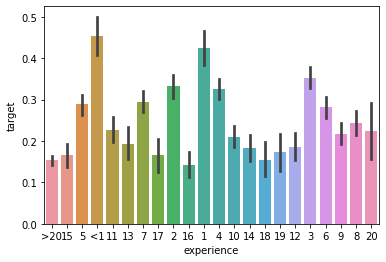

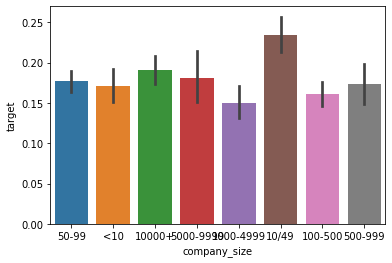

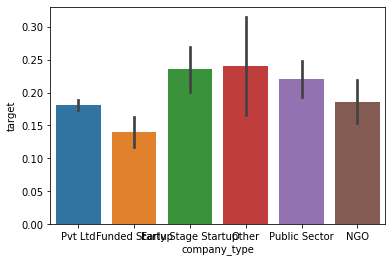

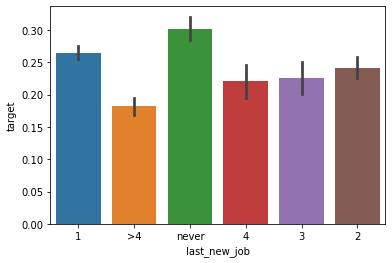

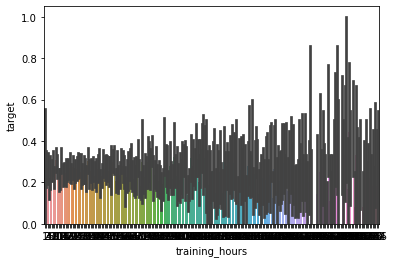

In [12]:
cols=df.drop(columns='target')
for c in cols.columns:
    sns.barplot(x=df[c], y=df['target'])
    plt.show()

In [13]:
#sns.pairplot(df)

In [14]:
df['target'].value_counts(normalize=True)

0.0    0.750652
1.0    0.249348
Name: target, dtype: float64

# Split up our data

In [15]:
X=df.drop(columns='target')
y=df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=22, stratify=y)

In [16]:
df.columns

Index(['city', 'city_development_index', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours', 'target'],
      dtype='object')

In [17]:
num_cols=['city_development_index', 'training_hours']
cat_cols=['city', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',]

In [18]:
preprocessing = ColumnTransformer(
    [
        ("scale", StandardScaler(), num_cols),
        ("encode", LeaveOneOutEncoder(), cat_cols),
    ],
    remainder="passthrough",
)

In [19]:
n_estimators = 100
learning_rate = 2 / n_estimators

pipeline = make_pipeline([
    #('sampling', SMOTE()),
    ('model', XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate)),
    ('preprocessing', preprocessing),
])

TypeError: Last step of Pipeline should implement fit or be the string 'passthrough'. '[('model', XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)), ('preprocessing', ColumnTransformer(remainder='passthrough',
                  transformers=[('scale', StandardScaler(),
                                 ['city_development_index', 'training_hours']),
                                ('encode', LeaveOneOutEncoder(),
                                 ['city', 'relevent_experience',
                                  'enrolled_university', 'education_level',
                                  'major_discipline', 'experience',
                                  'company_size', 'company_type',
                                  'last_new_job'])]))]' (type <class 'list'>) doesn't

In [ ]:
pipeline.fit(X_train, y_train)

train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

In [ ]:
grid = {
    "model__subsample": [0.5, 0.75, 1.0],
    "model__colsample_bytree": [0.5, 0.75, 1.0],
    "model__max_depth": [5, 7, 10],
}

In [ ]:
pipeline_cv = GridSearchCV(pipeline, grid, verbose=1, cv=5, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

In [ ]:
print(f"Train score: {pipeline_cv.score(X_train, y_train)}")
print(f"Test score: {pipeline_cv.score(X_test, y_test)}")

In [ ]:
pipeline_cv.best_params_

In [ ]:
p
# Isolating the 2 classes predictors
X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]

# Making up a limit to how many observations
# the majority class will have.
# Played with the number to end up with 1.3
n_0 = round(X_train_1.shape[0] * 1.3)
n_1 = X_train_1.shape[0]

# Sample majority class to have less observations
X_train_0_sample = X_train_0.sample(n_0, replace=False, random_state=42)

# Re-combine data (using the downsampled X for majority class)
X_train_downsample = pd.concat((X_train_1, X_train_0_sample))
X_train_downsample = X_train_downsample.reset_index(drop=True)

y_train_downsample = np.array([1] * n_1 + [0] * n_0)

In [ ]:
print(X_train_0.shape)
print(X_train_1.shape)

In [ ]:
params = {
    "model__subsample": [0.5, 0.75, 1.0],
    "model__colsample_bytree": [0.5, 0.75, 1.0],
    "model__max_depth": [3, 4, 5],
}

n_trees = 100
learning_rate = 2 / n_trees

pipeline["model"].n_estimators = n_trees
pipeline["model"].learning_rate = learning_rate

In [ ]:
pipeline_cv = GridSearchCV(pipeline, params, n_jobs=-1)
pipeline_cv.fit(X_train_downsample, y_train_downsample)

print(pipeline_cv.best_params_)

print(
    f"\nDownsampled train score: {pipeline_cv.score(X_train_downsample, y_train_downsample):.2f}"
)
print(f"Full train score: {pipeline_cv.score(X_train, y_train):.2f}")
print(f"Test score: {pipeline_cv.score(X_test, y_test):.2f}\n")

y_pred = pipeline_cv.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
confusion_mat = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(
    confusion_mat,
    index=["actual_Not_CHD", "actual_CHD"],
    columns=["pred_Not_CHD", "pred_CHD"],
)

In [ ]:
display(confusion_df)